# Figure S1 | Similarity between CCFv3 structures & t-types - ALL NUCLEI

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append("/code/")
from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import ccf_images as cimg
from abc_merfish_analysis import ccf_plots as cplots
from abc_merfish_analysis import ccf_erode as cerd
from abc_merfish_analysis import diversity_metrics as divmet
from abc_merfish_analysis import diversity_plots as dplot
from abc_merfish_analysis import distance_metrics as dm


from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

## Load thalamus data

In [2]:
obs_wmb = abc.get_combined_metadata()
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [3]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
z_col = 'z'+coords
section_col = 'brain_section_label'

In [4]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# Merge substructures into structures (esp. AMd + AMv -> AM; LGd-co + LGd-ip + LGd-sh -> LG)
ccf_images = cerd.merge_substructures(ccf_images, ccf_level='structure')

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[z_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [5]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() 

ccf_palette = abc.get_ccf_palette('substructure')
# ccf_palette['ZI'] = ccf_palette.pop('ZI-unassigned') # need to fix a key error

In [6]:
# We'll use the eroded CCF structures to calculate similarity metrics
ccf_metrics_level = "structure"
obs_erode, ccf_label_eroded = cerd.label_cells_by_eroded_ccf(obs_th, ccf_images, ccf_level=ccf_metrics_level, distance_px=5) # default is erosion by 5px (50um)
ccf_label = ccf_label_eroded
# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure
obs_erode.loc[lambda df: df['z_section']==6.6, ccf_label_eroded] = 'unassigned'

In [7]:
# if you reload abc_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

In [8]:
results_dir = '../../results'

## Set plotting parameters

In [ ]:
regions_to_plot = abc.TH_PARCELLATION_STRUCTURES

In [10]:
# set color map
cmap = dm.CMAP_PURPLES_256

# uncomment to show that colormap is perceptually uniform
# dm.plot_cmap_lightness(cmap)

# set colorbar range
vmin = 0
vmax = 0.8

### Fig. S1A | Similarity heatmap: Thalamic nuclei vs subclasses

### Fig. S1B | Similarity heatmap: Thalamic nuclei vs supertypes

### Fig. S1C | Similarity heatmap: Thalamic nuclei vs clusters

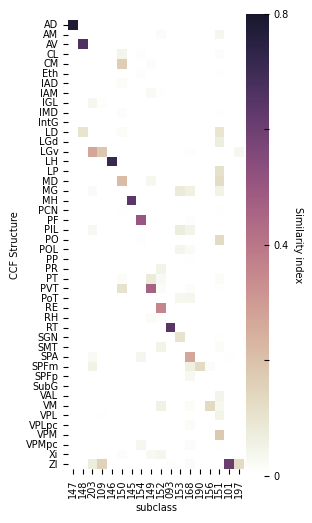

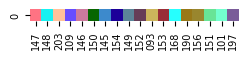

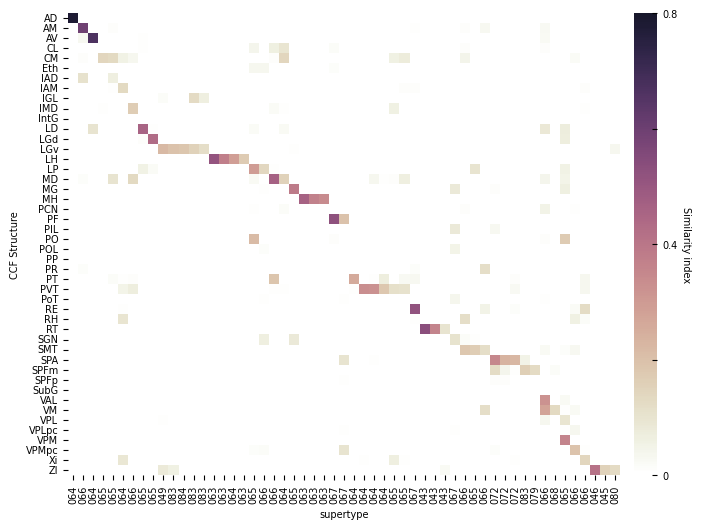

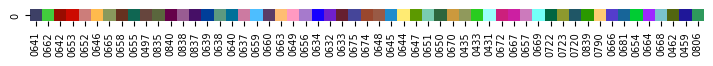

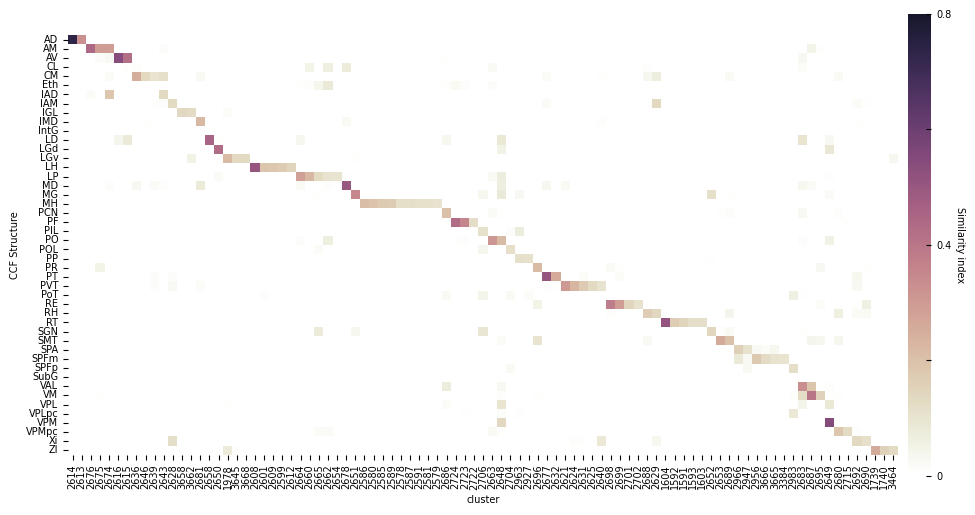

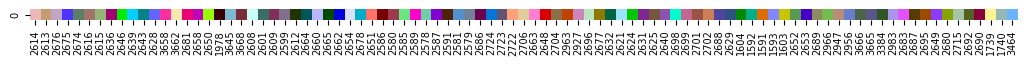

In [11]:
figure_index = 'S1'
panel_letter = ['A', 'B', 'C']

taxonomy_levels = ['subclass', 'supertype', 'cluster']
figure_sizes = [[1.5*1.8,2*3], [1.5*5.8,2*3], [1.5*8.5,2*3]]


for i, taxonomy_level in enumerate(taxonomy_levels):
    dist, y_names, x_names = dm.cluster_distances_from_labels(
                                obs_erode, y_col=ccf_label, x_col=taxonomy_level, 
                                y_names=sorted(regions_to_plot),
                                x_names=sorted(obs_erode[taxonomy_level].unique()))

    y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=False)

    x_names_ids_only = [name[0:4] for name in x_names] if taxonomy_level=='cluster' else [name[0:3] for name in x_names]

    fig_sim_hm = dm.plot_ordered_similarity_heatmap(
        dist, 
        y_order=y_order, x_order=x_order, 
        y_names=y_names, x_names=x_names_ids_only,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
    )

    # set figure size
    fig_size = figure_sizes[i]
    fig_sim_hm.set_size_inches(fig_size[0], fig_size[1])
    fig_sim_hm.gca().set_xlabel(taxonomy_level)
    fig_sim_hm.gca().set_ylabel('CCF Structure')

    fig_sim_hm.savefig(
        f'{results_dir}/fig{figure_index}{panel_letter[i]}_similarity_heatmap_nuclei_vs_{taxonomy_level}_ALL_NUCLEI.pdf', 
        transparent=True, bbox_inches='tight')
    # fig_sim_hm.savefig(
    #     f'{results_dir}/fig{figure_index}{panel_letter[i]}_similarity_heatmap_nuclei_vs_{taxonomy_level}_ALL_NUCLEI.png', 
    #     transparent=True, bbox_inches='tight',
    #     dpi=600)


    # Plot colored labels for the x-axis categories
    fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                    x_order, 
                                                    abc_palettes[taxonomy_level])
    fig_xlabel_colors.set_size_inches(fig_size[0], fig_size[1])
    fig_xlabel_colors.savefig(
        f'{results_dir}/fig{figure_index}{panel_letter[i]}_similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
        transparent=True, bbox_inches='tight')